In [3]:
import regex as re
import numpy as np
import pandas as pd 
import datetime
import nltk
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Plotting tools
import pyLDAvis

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
# spacy for lemmatization
import spacy

In [4]:
# retrieving file with collected Facebook data
fb_data = pd.read_csv('facebook_covid_posts_updated.csv', encoding = "latin1")
fb_data.head(2)

,Unnamed: 0,Unnamed: 0.1,News Org.,Post's Title,Added link,Time Posted,Posted By,# Shares,# Total Reactions,# Like,# Love,# Haha,# Wow,# Sad,# Angry,# Comments,Post's Text
0,0,1,CNN,Thousands of meals meant for an Ohio sports fe...,https://cnn.it/2VUDfSU,2020-03-07,CNN,3630.0,18595.0,13710.0,4736.0,8.0,94.0,44.0,3.0,272.0,Instead of throwing it away because of a chang...
1,1,2,CNN,"In the middle of a coronavirus outbreak, peopl...",https://cnn.it/330y3y0,2020-03-07,CNN,189.0,874.0,595.0,10.0,12.0,80.0,172.0,5.0,153.0,There's a new reality beginning to form in the...


In [7]:
data=[fb_data['News Org.'], fb_data['Time Posted'], fb_data["Post's Title"], fb_data["Post's Text"],
      fb_data['# Shares'], fb_data['# Comments'], fb_data['# Total Reactions'], fb_data["# Like"], 
      fb_data['# Love'], fb_data['# Haha'], fb_data['# Wow'], fb_data["# Sad"], fb_data['# Angry']]
      
headers =  ['organization', 'date', 'title', 'post', 'shares', 'comments', 'total_reactions', 'like', 'love',
             'haha', 'wow', 'sad', 'angry']       
df1 = pd.concat(data, keys=headers, axis=1, )   
df1.head()

,organization,date,title,post,shares,comments,total_reactions,like,love,haha,wow,sad,angry
0,CNN,2020-03-07,Thousands of meals meant for an Ohio sports fe...,Instead of throwing it away because of a chang...,3630.0,272.0,18595.0,13710.0,4736.0,8.0,94.0,44.0,3.0
1,CNN,2020-03-07,"In the middle of a coronavirus outbreak, peopl...",There's a new reality beginning to form in the...,189.0,153.0,874.0,595.0,10.0,12.0,80.0,172.0,5.0
2,CNN,2020-03-07,Coronavirus spreads as outbreak clusters grow ...,The number of US coronavirus cases more than t...,473.0,372.0,1653.0,1010.0,11.0,16.0,190.0,416.0,10.0
3,CNN,2020-03-07,Adoptions from China are being held up by the ...,Many families in the US were just days or week...,6400.0,1576.0,24250.0,13370.0,3659.0,94.0,381.0,6661.0,85.0
4,CNN,2020-03-06,Anderson Cooper Full Circle - CNN,Weâll speak with Amir Medawar who pushed to ...,30.0,58.0,278.0,173.0,3.0,0.0,19.0,79.0,4.0


In [8]:
# removing rows with no posts
df1 = df1[df1['post'].notna()]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4557 entries, 0 to 4961
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   organization     4557 non-null   object 
 1   date             4557 non-null   object 
 2   title            4367 non-null   object 
 3   post             4557 non-null   object 
 4   shares           4557 non-null   float64
 5   comments         4557 non-null   float64
 6   total_reactions  4557 non-null   float64
 7   like             4557 non-null   float64
 8   love             4557 non-null   float64
 9   haha             4557 non-null   float64
 10  wow              4557 non-null   float64
 11  sad              4557 non-null   float64
 12  angry            4557 non-null   float64
dtypes: float64(9), object(4)
memory usage: 498.4+ KB


In [9]:
# replacing missing titles with empty strings
df1.fillna("",inplace=True)

In [10]:
# Converting date to datetime format and extracting year and month only (omitting a "day" information)
df1['yearMonth'] = pd.to_datetime(df1['date'])
df1['yearMonth'] = df1['yearMonth'].dt.strftime('%Y-%m')
df1.head(2)

,organization,date,title,post,shares,comments,total_reactions,like,love,haha,wow,sad,angry,yearMonth
0,CNN,2020-03-07,Thousands of meals meant for an Ohio sports fe...,Instead of throwing it away because of a chang...,3630.0,272.0,18595.0,13710.0,4736.0,8.0,94.0,44.0,3.0,2020-03
1,CNN,2020-03-07,"In the middle of a coronavirus outbreak, peopl...",There's a new reality beginning to form in the...,189.0,153.0,874.0,595.0,10.0,12.0,80.0,172.0,5.0,2020-03


In [11]:
# creating dataframe with number of posts by each organization in every month data was collected for
monthlyPosts = df1.groupby(['yearMonth', 'organization']).size().reset_index().rename(columns={0: 'postsCount'})
monthlyPosts = monthlyPosts.sort_values(['yearMonth', 'postsCount'], ascending = (True, False))
monthlyPosts

,yearMonth,organization,postsCount
0,2020-03,ABCNews,248
2,2020-03,CNN,199
4,2020-03,NBC,159
9,2020-03,WSJ,151
5,2020-03,NYT,150
...,...,...,...
86,2021-03,WASH,10
91,2021-04,WSJ,57
88,2021-04,ABCNews,29
90,2021-04,USAToday,20


In [12]:
# Creating a pivot table with Covid-related FB posts per organization per month
postCountsPivot=pd.pivot_table(monthlyPosts,index=['organization'],columns='yearMonth',values='postsCount',aggfunc=sum,fill_value=0)
postCountsPivot

yearMonth,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04
organization,,,,,,,,,,,,,
ABCNews,248,0,0,69,0,0,45,0,108,1,0,88,29
BBC,45,9,28,23,7,12,16,23,23,0,22,20,0
CNN,199,0,24,93,0,9,74,19,118,0,44,110,0
FOX,46,0,6,8,0,4,3,8,25,1,4,10,0
NBC,159,0,0,68,0,0,51,0,111,4,0,71,0
NYT,150,0,12,74,0,8,72,0,108,1,7,94,0
TheGuardian,81,0,0,18,0,1,18,2,30,0,11,31,7
USAToday,135,0,77,49,0,16,55,33,101,0,67,85,20
WASH,48,0,25,23,0,13,18,21,21,1,10,10,0


In [13]:
# dataframe ready for text cleanup and processing
df1.columns

Index(['organization', 'date', 'title', 'post', 'shares', 'comments',
       'total_reactions', 'like', 'love', 'haha', 'wow', 'sad', 'angry',
       'yearMonth'],
      dtype='object')

In [14]:
# creating a list objects for all the posts per each organization (...as well as their titles and combining them)

postsABCNews= df1['post'][df1['organization'] == 'ABCNews'].tolist()
titlesABCNews = df1['title'][df1['organization'] == 'ABCNews'].tolist()
allABCNews = postsABCNews + titlesABCNews
len(allABCNews)

1176

In [15]:
postsBBC= df1['post'][df1['organization'] == 'BBC'].tolist()
titlesBBC = df1['title'][df1['organization'] == 'BBC'].tolist()
allBBC = postsBBC + titlesBBC
len(allBBC)

456

In [16]:
postsCNN= df1['post'][df1['organization'] == 'CNN'].tolist()
titlesCNN = df1['title'][df1['organization'] == 'CNN'].tolist()
allCNN = postsCNN + titlesCNN
len(allCNN)

1380

In [17]:
postsFOX= df1['post'][df1['organization'] == 'FOX'].tolist()
titlesFOX = df1['title'][df1['organization'] == 'FOX'].tolist()
allFOX = postsFOX + titlesFOX
len(allFOX)

230

In [18]:
postsNBC= df1['post'][df1['organization'] == 'NBC'].tolist()
titlesNBC = df1['title'][df1['organization'] == 'NBC'].tolist()
allNBC = postsNBC + titlesNBC
len(allNBC)

928

In [19]:
postsNYT= df1['post'][df1['organization'] == 'NYT'].tolist()
titlesNYT = df1['title'][df1['organization'] == 'NYT'].tolist()
allNYT = postsNYT + titlesNYT
len(allNYT)

1052

In [20]:
postsTheGuardian= df1['post'][df1['organization'] == 'TheGuardian'].tolist()
titlesTheGuardian = df1['title'][df1['organization'] == 'TheGuardian'].tolist()
allTheGuardian = postsTheGuardian + titlesTheGuardian
len(allTheGuardian)

398

In [21]:
postsUSAToday= df1['post'][df1['organization'] == 'USAToday'].tolist()
titlesUSAToday = df1['title'][df1['organization'] == 'USAToday'].tolist()
allUSAToday = postsUSAToday + titlesUSAToday
len(allUSAToday)

1276

In [22]:
postsWASH= df1['post'][df1['organization'] == 'WASH'].tolist()
titlesWASH = df1['title'][df1['organization'] == 'WASH'].tolist()
allWASH = postsWASH + titlesWASH
len(allWASH)

380

In [23]:
postsWSJ= df1['post'][df1['organization'] == 'WSJ'].tolist()
titlesWSJ = df1['title'][df1['organization'] == 'WSJ'].tolist()
allWSJ = postsWSJ + titlesWSJ
len(allWSJ)

1838

In [24]:
from nltk.corpus import stopwords

myStopWords = stopwords.words('english')

# adding to corpus some custom words that are irrelevant yet appearing frequently 
# (e.g. many posts start with "HAPPENING NOW:" or "BREAKING NEWS:")
myStopWords.extend(['happening', 'breaking', 'watch', 'live', 'com', 'â', 'update', 'timeline', 'photo','photos' '000',
                    'happening_now', 'breaking_news', 'u', 'watch_life', 'timeline_photos', 'live_updates', 'ha', 'wa']) 

print(sorted(myStopWords))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'breaking', 'breaking_news', 'but', 'by', 'can', 'com', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'ha', 'had', 'hadn', "hadn't", 'happening', 'happening_now', 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'live', 'live_updates', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'photo', 'photos0

In [25]:
# this is a list of lists for each organization's FB posted text content
allPosts = [allABCNews, allBBC, allCNN, allFOX, allNBC, allNYT, allTheGuardian, allUSAToday, allWASH, allWSJ]
allPosts[0][0:5]

['HAPPENING NOW: North Carolina Gov. Roy Cooper gives updates on the novel coronavirus. https://abcn.ws/39Xu2gQ',
 'Guests are jittery, travel is tangled, and soon-to-be brides and grooms are facing tough choices because of the coronavirus outbreak: postpone, cancel or forge ahead with their weddings?',
 'CORONAVIRUS UPDATES: Officials around the country give updates the novel coronavirus. https://abcn.ws/2vnaW4D',
 'New York City Mayor Bill de Blasio gives updates on the novel coronavirus after New York State confirmed its first death. https://abcn.ws/2U4WJBE',
 'HAPPENING NOW: Pres. Trump and Vice Pres. Mike Pence hold a press conference with the coronavirus task force. https://abcn.ws/2vq7UN0']

In [27]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
import nltk
#nltk.download('punkt')
# cleaning posts' text

allCleanPosts = []     #     <-- a new list to hold lists with cleaned text of FB posts for each organization

for index in range(0,10):
    organizationPosts = allPosts[index];
    cleanOrganizationPosts = []
    for item in organizationPosts:
        
        #removing urls
        item = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', item)
       
        # removing whitespace characters (tabs, new line, etc.)
        item = re.sub('\s+', ' ', item) 
    
        # removing non-alphanumberic characters (dots, commas, special characters if any, etc.)
        item = re.sub('\W+', ' ', item)
            
        # changing to lowercase and tokanizing 
        item = nltk.word_tokenize(item.lower())
                      
        #appending cleaned post to the list              
        cleanOrganizationPosts.append(item)  
        
    allCleanPosts.append(cleanOrganizationPosts)
    
print(allCleanPosts[0][0:5])  

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Arthur\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


[['happening', 'now', 'north', 'carolina', 'gov', 'roy', 'cooper', 'gives', 'updates', 'on', 'the', 'novel', 'coronavirus'], ['guests', 'are', 'jittery', 'travel', 'is', 'tangled', 'and', 'soon', 'to', 'be', 'brides', 'and', 'grooms', 'are', 'facing', 'tough', 'choices', 'because', 'of', 'the', 'coronavirus', 'outbreak', 'postpone', 'cancel', 'or', 'forge', 'ahead', 'with', 'their', 'weddings'], ['coronavirus', 'updates', 'officials', 'around', 'the', 'country', 'give', 'updates', 'the', 'novel', 'coronavirus'], ['new', 'york', 'city', 'mayor', 'bill', 'de', 'blasio', 'gives', 'updates', 'on', 'the', 'novel', 'coronavirus', 'after', 'new', 'york', 'state', 'confirmed', 'its', 'first', 'death'], ['happening', 'now', 'pres', 'trump', 'and', 'vice', 'pres', 'mike', 'pence', 'hold', 'a', 'press', 'conference', 'with', 'the', 'coronavirus', 'task', 'force']]


In [28]:
# adding bigrams if any are detected
allPostsWithBigram = []
for index in range(0,10):
    orgPosts = allCleanPosts[index]
    
    # creating a set of bigrams for pairs of words frequently occuring in the the same posts 
    bigrams = gensim.models.Phrases(orgPosts, min_count=5, threshold=80) 

    # building bigram model
    bigram_mod = gensim.models.phrases.Phraser(bigrams)
    
    orgPostsWithBigram = []  
    for post in orgPosts:
        post_ = bigram_mod[post]
        
        orgPostsWithBigram.append(post_)
        
    allPostsWithBigram.append(orgPostsWithBigram)
    
print(allPostsWithBigram[0][0:5] )   
 

[['happening_now', 'north', 'carolina', 'gov', 'roy', 'cooper', 'gives', 'updates', 'on', 'the', 'novel', 'coronavirus'], ['guests', 'are', 'jittery', 'travel', 'is', 'tangled', 'and', 'soon', 'to', 'be', 'brides', 'and', 'grooms', 'are', 'facing', 'tough', 'choices', 'because', 'of', 'the', 'coronavirus', 'outbreak', 'postpone', 'cancel', 'or', 'forge', 'ahead', 'with', 'their', 'weddings'], ['coronavirus', 'updates', 'officials', 'around', 'the', 'country', 'give', 'updates', 'the', 'novel', 'coronavirus'], ['new', 'york_city', 'mayor', 'bill', 'de_blasio', 'gives', 'updates', 'on', 'the', 'novel', 'coronavirus', 'after', 'new', 'york', 'state', 'confirmed', 'its', 'first', 'death'], ['happening_now', 'pres', 'trump', 'and', 'vice', 'pres', 'mike_pence', 'hold', 'a', 'press_conference', 'with', 'the', 'coronavirus', 'task_force']]


In [29]:
import spacy 
nlp = spacy.load('en_core_web_sm')  # <--downloading English core

In [31]:
#import nltk
#nltk.download('wordnet')

lemmatizer = nltk.stem.WordNetLemmatizer() 
orgs = []  # <-- new list to hold lammatized content


for index in range(0,10):
    lemmaPosts = []   # temp list to hold lammatized posts for one of the iterated company's lists of posts
    
    for p in allPostsWithBigram[index]: 
        lemma_post = [lemmatizer.lemmatize(t) for t in p]
        lemmaPosts.append(lemma_post)
        
    orgs.append(lemmaPosts)  
    
print(orgs[0][0:5])   #<-- printing sample of lammatized content    

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Arthur\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


[['happening_now', 'north', 'carolina', 'gov', 'roy', 'cooper', 'give', 'update', 'on', 'the', 'novel', 'coronavirus'], ['guest', 'are', 'jittery', 'travel', 'is', 'tangled', 'and', 'soon', 'to', 'be', 'bride', 'and', 'groom', 'are', 'facing', 'tough', 'choice', 'because', 'of', 'the', 'coronavirus', 'outbreak', 'postpone', 'cancel', 'or', 'forge', 'ahead', 'with', 'their', 'wedding'], ['coronavirus', 'update', 'official', 'around', 'the', 'country', 'give', 'update', 'the', 'novel', 'coronavirus'], ['new', 'york_city', 'mayor', 'bill', 'de_blasio', 'give', 'update', 'on', 'the', 'novel', 'coronavirus', 'after', 'new', 'york', 'state', 'confirmed', 'it', 'first', 'death'], ['happening_now', 'pres', 'trump', 'and', 'vice', 'pres', 'mike_pence', 'hold', 'a', 'press_conference', 'with', 'the', 'coronavirus', 'task_force']]


In [32]:
def remove_stopwords(texts, stop_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

allEntries = []

for i in range(0,10):
    compPosts = orgs[i]
    cleanEntries = remove_stopwords(compPosts, myStopWords)
    allEntries.append(cleanEntries)   
    
print(allEntries[0][0:5])   

[['north', 'carolina', 'gov', 'roy', 'cooper', 'give', 'novel', 'coronavirus'], ['guest', 'jittery', 'travel', 'tangled', 'soon', 'bride', 'groom', 'facing', 'tough', 'choice', 'coronavirus', 'outbreak', 'postpone', 'cancel', 'forge', 'ahead', 'wedding'], ['coronavirus', 'official', 'around', 'country', 'give', 'novel', 'coronavirus'], ['new', 'york_city', 'mayor', 'bill', 'de_blasio', 'give', 'novel', 'coronavirus', 'new', 'york', 'state', 'confirmed', 'first', 'death'], ['pres', 'trump', 'vice', 'pres', 'mike_pence', 'hold', 'coronavirus', 'task_force']]


In [33]:
# creating dictionary
orgPosts = allEntries[0]            #<-- posted content by ABCNews *********
id2word = corpora.Dictionary(orgPosts)

texts = orgPosts

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]

# sample view of sorted words' frequencies in the firsts post
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[('carolina', 1), ('cooper', 1), ('coronavirus', 1), ('give', 1), ('gov', 1), ('north', 1), ('novel', 1), ('roy', 1)]]


In [34]:
# creating a topic model with 3 most distinguishable topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# printing keywords in each of the 3 topics and the weight of their contribution to that topic
lda_model.print_topics()

[(0,
  '0.065*"covid" + 0.061*"coronavirus" + 0.033*"novel" + 0.027*"give" + 0.023*"gov" + 0.021*"new" + 0.014*"hold" + 0.012*"pandemic" + 0.012*"vaccine" + 0.011*"mayor"'),
 (1,
  '0.029*"vaccine" + 0.028*"covid" + 0.025*"pandemic" + 0.013*"latest" + 0.012*"know" + 0.009*"say" + 0.009*"coronavirus" + 0.007*"biden" + 0.007*"need" + 0.007*"pfizer"'),
 (2,
  '0.025*"covid" + 0.018*"pandemic" + 0.015*"coronavirus" + 0.014*"year" + 0.010*"new" + 0.010*"american" + 0.010*"health" + 0.007*"amid" + 0.005*"vaccination" + 0.005*"due"')]

In [35]:
import wordcloud

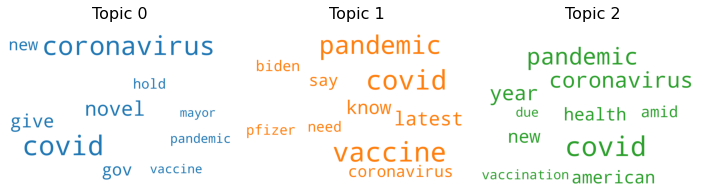

In [36]:
from matplotlib import pyplot as plt

from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [37]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

#************************************ below is for ABCNews *************************************

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.181585 -0.005749       1        1  40.316754
2      0.096581 -0.132393       2        1  30.140456
1      0.085004  0.138142       3        1  29.542790, topic_info=            Term        Freq       Total Category  logprob  loglift
6          novel  138.000000  138.000000  Default  30.0000  30.0000
3           give  112.000000  112.000000  Default  29.0000  29.0000
4            gov   95.000000   95.000000  Default  28.0000  28.0000
2    coronavirus  329.000000  329.000000  Default  27.0000  27.0000
408      vaccine  137.000000  137.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
48         covid   86.089496  436.010357   Topic3  -3.5689  -0.4029
862     hospital   12.036082   15.663415   Topic3  -5.5363   0.9559
173          get   12.554498   18.828651   Topic3  -5.4942   0.8140
2    coronavirus   26.576834  329.545252   Topic3  -4.7442  -1.2983
78      abc_news   14.255829   46.667947   Topic3  -5.3671   0.0334

[160 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
78        1  0.685695   abc_news
78        3  0.299992   abc_news
90        1  0.978310    abcn_ws
132       1  0.220179   american
132       2  0.733929   american
...     ...       ...        ...
36        1  0.905316  york_city
36        2  0.106508  york_city
410       3  0.976879   you_need
1043      2  0.052414      young
1043      3  0.943446      young

[164 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [38]:
# creating dictionary
orgPosts = allEntries[1]  #<-- posted content by BBC *********
id2word = corpora.Dictionary(orgPosts)

texts = orgPosts

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]
# creating a topic model with 3 most distinguishable topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


# printing keywords in each of the 3 topics and the weight of their contribution to that topic
lda_model.print_topics()

[(0,
  '0.036*"covid" + 0.008*"new" + 0.008*"england" + 0.008*"coronavirus" + 0.006*"bbc" + 0.006*"london" + 0.006*"face" + 0.006*"case" + 0.006*"variant" + 0.006*"begin"'),
 (1,
  '0.045*"vaccine" + 0.030*"covid" + 0.015*"uk" + 0.012*"bbc" + 0.012*"coronavirus" + 0.010*"pandemic" + 0.007*"people" + 0.007*"risk" + 0.006*"second" + 0.006*"hospital"'),
 (2,
  '0.033*"coronavirus" + 0.022*"covid" + 0.021*"uk" + 0.009*"case" + 0.008*"one" + 0.008*"million" + 0.008*"pandemic" + 0.007*"lockdown" + 0.007*"bbc" + 0.006*"people"')]

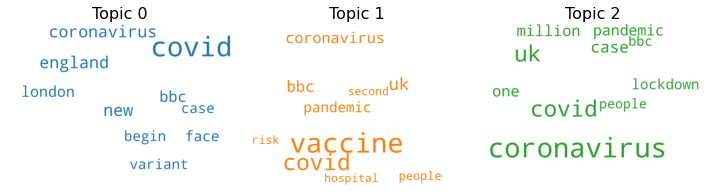

In [39]:
topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [40]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

#************************************ below is for BBC **************************************

vis        

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.101887 -0.073054       1        1  45.069919
1     -0.119450 -0.044961       2        1  30.945207
0      0.017563  0.118015       3        1  23.984874, topic_info=            Term        Freq       Total Category  logprob  loglift
750      vaccine   65.000000   65.000000  Default  30.0000  30.0000
89            uk   66.000000   66.000000  Default  29.0000  29.0000
177        covid  127.000000  127.000000  Default  28.0000  28.0000
59           one   18.000000   18.000000  Default  27.0000  27.0000
58       million   18.000000   18.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
161          day    4.675748   13.362820   Topic3  -5.4656   0.3777
14   coronavirus    8.544908   94.333340   Topic3  -4.8627  -0.9738
80           get    3.526792    9.310760   Topic3  -5.7476   0.4570
202         said    3.608369   10.857608   Topic3  -5.7248   0.3261
76         world    3.287249   12.744889   Topic3  -5.8180   0.0727

[178 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
432       1  0.918124     across
374       2  0.744398   antibody
1501      3  0.884588  arboretum
838       3  0.884619      asian
1069      2  0.883921        ban
...     ...       ...        ...
76        1  0.470777      world
76        2  0.235388      world
76        3  0.235388      world
274       1  0.940461       year
1660      3  0.831936    zealand

[188 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [41]:
# creating dictionary
orgPosts = allEntries[2]         #<-- posted content by CNN ********* 
id2word = corpora.Dictionary(orgPosts)

texts = orgPosts

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]
# creating a topic model with 3 most distinguishable topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


# printing keywords in each of the 3 topics and the weight of their contribution to that topic
lda_model.print_topics()

[(0,
  '0.028*"coronavirus" + 0.019*"case" + 0.015*"covid" + 0.014*"cnn" + 0.012*"new" + 0.008*"vaccine" + 0.008*"find" + 0.006*"florida" + 0.006*"dr_sanjay" + 0.005*"state"'),
 (1,
  '0.052*"covid" + 0.029*"vaccine" + 0.020*"coronavirus" + 0.017*"say" + 0.010*"pandemic" + 0.010*"get" + 0.009*"american" + 0.008*"trump" + 0.007*"biden" + 0.007*"cdc"'),
 (2,
  '0.015*"pandemic" + 0.014*"coronavirus" + 0.010*"first" + 0.008*"people" + 0.008*"million" + 0.007*"state" + 0.007*"year" + 0.007*"analysis" + 0.006*"say" + 0.006*"death"')]

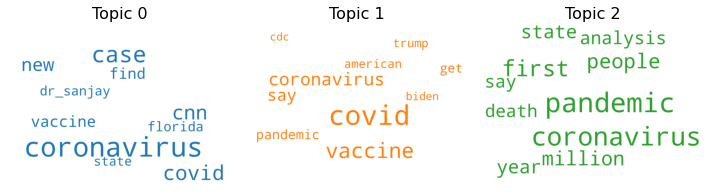

In [42]:
topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [43]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

#************************************ below is for CNN **************************************

vis           

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.154545 -0.079571       1        1  42.368032
2     -0.152898 -0.082171       2        1  33.285978
0     -0.001647  0.161742       3        1  24.345989, topic_info=         Term        Freq       Total Category  logprob  loglift
242     covid  536.000000  536.000000  Default  30.0000  30.0000
35       case   91.000000   91.000000  Default  29.0000  29.0000
725   vaccine  287.000000  287.000000  Default  28.0000  28.0000
76        cnn   75.000000   75.000000  Default  27.0000  27.0000
260     first   66.000000   66.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
1977    surge   17.145326   32.039375   Topic3  -5.6243   0.7876
113     world   18.094427   42.305095   Topic3  -5.5704   0.5635
3203  variant   14.213995   26.115828   Topic3  -5.8118   0.8045
269       two   14.225305   35.265274   Topic3  -5.8110   0.5049
745    report   14.205306   38.897777   Topic3  -5.8124   0.4055

[167 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
317       3  0.933524             air
397       1  0.991079        american
398       1  0.975164            amid
588       2  0.974918        analysis
2876      1  0.959923           biden
...     ...       ...             ...
113       2  0.023638           world
113       3  0.425481           world
1054      2  0.989726            year
629       1  0.945341        year_old
284       3  0.942044  your_questions

[196 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [44]:
# creating dictionary
orgPosts = allEntries[3]        #<-- posted content by FOX ********* 
id2word = corpora.Dictionary(orgPosts)

texts = orgPosts

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]
# creating a topic model with 3 most distinguishable topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


# printing keywords in each of the 3 topics and the weight of their contribution to that topic
lda_model.print_topics()

[(0,
  '0.022*"coronavirus" + 0.019*"covid" + 0.013*"gov" + 0.012*"hold" + 0.012*"service" + 0.012*"briefing" + 0.012*"response" + 0.011*"california" + 0.010*"gavin_newsom" + 0.009*"cuomo"'),
 (1,
  '0.029*"coronavirus" + 0.025*"president" + 0.023*"covid" + 0.020*"hold" + 0.015*"senate" + 0.012*"briefing" + 0.012*"vice" + 0.011*"vaccine" + 0.010*"relief" + 0.009*"elect"'),
 (2,
  '0.020*"covid" + 0.018*"vaccine" + 0.016*"coronavirus" + 0.013*"relief" + 0.011*"bill" + 0.009*"house" + 0.009*"state" + 0.008*"stimulus" + 0.008*"mask" + 0.008*"federal"')]

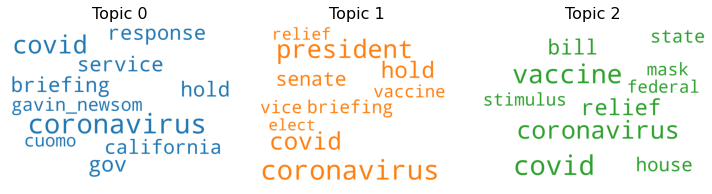

In [45]:
topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [46]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word) 

#************************************ below is for FOX **************************************

vis     

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.086626 -0.079754       1        1  45.786437
2     -0.117214 -0.030238       2        1  28.620121
0      0.030589  0.109991       3        1  25.593442, topic_info=          Term       Freq      Total Category  logprob  loglift
11   president  26.000000  26.000000  Default  30.0000  30.0000
19        hold  27.000000  27.000000  Default  29.0000  29.0000
252    service   9.000000   9.000000  Default  28.0000  28.0000
60         gov  12.000000  12.000000  Default  27.0000  27.0000
14        vice  12.000000  12.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
365      child   3.799357   6.376492   Topic3  -4.9972   0.8450
194        fox   3.799470   8.233798   Topic3  -4.9972   0.5894
453    vaccine   4.466801  27.310547   Topic3  -4.8353  -0.4478
115      house   4.045862  14.437223   Topic3  -4.9343   0.0907
38       state   3.736194  14.676671   Topic3  -5.0139  -0.0054

[171 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
288       1  0.740841     american
288       2  0.148168     american
562       3  0.930658        among
276       1  0.858451      another
791       2  0.766101  astrazeneca
...     ...       ...          ...
243       2  0.101498         vote
608       1  0.889774         warp
275       3  0.971672       worker
774       2  0.221494       yellen
774       3  0.664482       yellen

[175 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [47]:
# creating dictionary
orgPosts = allEntries[4]           #<-- posted content by NBC ********* 
id2word = corpora.Dictionary(orgPosts)

texts = orgPosts

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]
# creating a topic model with 3 most distinguishable topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


# printing keywords in each of the 3 topics and the weight of their contribution to that topic
lda_model.print_topics()

[(0,
  '0.039*"covid" + 0.018*"coronavirus" + 0.017*"vaccination" + 0.013*"say" + 0.011*"worker" + 0.011*"month" + 0.010*"line" + 0.010*"one" + 0.010*"cruise" + 0.010*"ship"'),
 (1,
  '0.037*"covid" + 0.037*"vaccine" + 0.022*"coronavirus" + 0.009*"get" + 0.008*"young" + 0.008*"first" + 0.007*"report" + 0.007*"say" + 0.007*"test" + 0.007*"health"'),
 (2,
  '0.032*"covid" + 0.025*"coronavirus" + 0.023*"pandemic" + 0.012*"american" + 0.011*"trump" + 0.011*"year" + 0.008*"biden" + 0.008*"help" + 0.006*"day" + 0.006*"end"')]

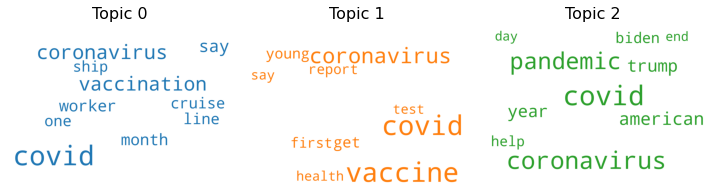

In [48]:
topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [49]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

#************************************ below is for NBC **************************************

vis              

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.129261  0.119339       1        1  36.804096
1     -0.054349 -0.156908       2        1  33.140337
0      0.183610  0.037569       3        1  30.055567, topic_info=             Term        Freq       Total Category  logprob  loglift
438       vaccine  128.000000  128.000000  Default  30.0000  30.0000
1770  vaccination   55.000000   55.000000  Default  29.0000  29.0000
13       american   47.000000   47.000000  Default  28.0000  28.0000
288         trump   43.000000   43.000000  Default  27.0000  27.0000
1336         year   43.000000   43.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
994          wave   16.177910   19.198553   Topic3  -5.2663   1.0309
81           case   26.416170   49.664754   Topic3  -4.7760   0.5708
2     coronavirus   57.541834  228.699094   Topic3  -3.9974  -0.1778
352         child   17.637926   23.812937   Topic3  -5.1799   0.9019
55       pandemic   20.390829  117.871758   Topic3  -5.0349  -0.5524

[168 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
1695      1  0.914459  administration
2279      2  0.986227           adult
2564      3  0.960957          afraid
652       1  0.907678             aid
652       2  0.075640             aid
...     ...       ...             ...
61        3  0.713175          worker
596       1  0.815600           world
596       2  0.152925           world
1336      1  0.985182            year
2252      2  0.992414           young

[169 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [50]:
# creating dictionary
orgPosts = allEntries[5]       #<-- posted content by NYT (New York Times) ********* 
id2word = corpora.Dictionary(orgPosts)

texts = orgPosts

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]
# creating a topic model with 3 most distinguishable topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


# printing keywords in each of the 3 topics and the weight of their contribution to that topic
lda_model.print_topics()

[(0,
  '0.019*"coronavirus" + 0.016*"pandemic" + 0.009*"covid_" + 0.007*"trial" + 0.006*"new_york" + 0.006*"opinion" + 0.006*"new" + 0.006*"one" + 0.005*"lockdown" + 0.005*"result"'),
 (1,
  '0.022*"coronavirus" + 0.020*"pandemic" + 0.012*"covid" + 0.007*"case" + 0.007*"death" + 0.007*"like" + 0.006*"worker" + 0.006*"year" + 0.005*"new" + 0.005*"covid_"'),
 (2,
  '0.040*"vaccine" + 0.023*"coronavirus" + 0.015*"virus" + 0.012*"first" + 0.008*"get" + 0.007*"could" + 0.007*"state" + 0.006*"astrazeneca" + 0.006*"people" + 0.005*"astrazenecaâ"')]

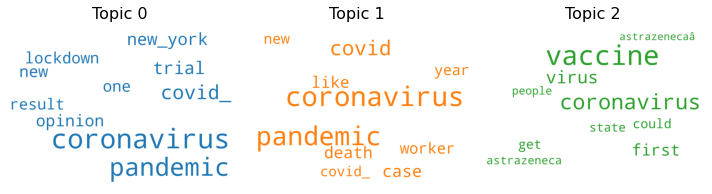

In [51]:
topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [52]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

#************************************ below is for NYT **************************************

vis    

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.063920  0.131931       1        1  34.962431
0     -0.095594 -0.115551       2        1  32.905172
2      0.159514 -0.016381       3        1  32.132397, topic_info=          Term        Freq       Total Category  logprob  loglift
1513   vaccine  164.000000  164.000000  Default  30.0000  30.0000
81       virus   60.000000   60.000000  Default  29.0000  29.0000
353      first   51.000000   51.000000  Default  28.0000  28.0000
434   pandemic  167.000000  167.000000  Default  27.0000  27.0000
1950     covid   65.000000   65.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
2988     biden   12.948516   18.773755   Topic3  -5.7622   0.7638
33         new   16.587551   65.645517   Topic3  -5.5146  -0.2403
34    new_york   16.064057   61.583742   Topic3  -5.5466  -0.2085
134       case   14.539888   47.319791   Topic3  -5.6463  -0.0447
1950     covid   12.547443   65.239456   Topic3  -5.7937  -0.5132

[168 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
813       1  0.962180       across
350       1  0.444807     american
350       2  0.549468     american
371       1  0.927490         amid
2266      2  0.040954  astrazeneca
...     ...       ...          ...
361       1  0.971816       worker
159       1  0.806485        world
159       2  0.161297        world
160       1  0.765552         year
160       2  0.235554         year

[181 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [53]:
# creating dictionary
orgPosts = allEntries[6]          #<-- posted content by The Guardian ********* 
id2word = corpora.Dictionary(orgPosts)

texts = orgPosts

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]
# creating a topic model with 3 most distinguishable topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


# printing keywords in each of the 3 topics and the weight of their contribution to that topic
lda_model.print_topics()

[(0,
  '0.026*"covid" + 0.016*"coronavirus" + 0.015*"vaccine" + 0.013*"uk" + 0.008*"year" + 0.008*"life" + 0.006*"people" + 0.005*"say" + 0.005*"pandemic" + 0.005*"woman"'),
 (1,
  '0.023*"covid" + 0.023*"coronavirus" + 0.008*"pandemic" + 0.007*"home" + 0.007*"uk" + 0.006*"like" + 0.005*"crisis" + 0.005*"outbreak" + 0.005*"global" + 0.005*"video"'),
 (2,
  '0.024*"coronavirus" + 0.020*"covid" + 0.012*"uk" + 0.008*"pandemic" + 0.008*"case" + 0.007*"say" + 0.007*"new" + 0.006*"england" + 0.006*"lockdown" + 0.005*"school"')]

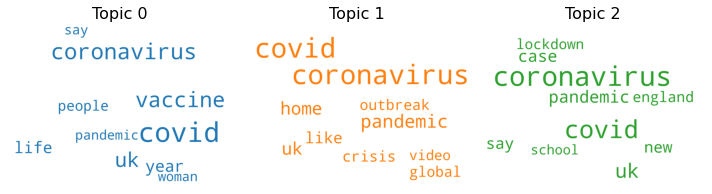

In [54]:
topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [55]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

#************************************ below is for The Guardian **************************************

vis    

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.110899 -0.038662       1        1  35.917309
1      0.090293 -0.072957       2        1  34.657909
2      0.020606  0.111619       3        1  29.424782, topic_info=         Term       Freq      Total Category  logprob  loglift
649   vaccine  20.000000  20.000000  Default  30.0000  30.0000
520      year  11.000000  11.000000  Default  29.0000  29.0000
280      life  10.000000  10.000000  Default  28.0000  28.0000
291      like   7.000000   7.000000  Default  27.0000  27.0000
76        new  10.000000  10.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
8    pandemic   9.056172  26.453072   Topic3  -4.7825   0.1514
243      york   2.583870   3.478450   Topic3  -6.0367   0.9260
56       plan   3.012099   6.314323   Topic3  -5.8833   0.4831
947      amid   2.695423   5.703745   Topic3  -5.9944   0.4738
84   american   2.590387   6.536705   Topic3  -6.0342   0.2977

[172 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
128       2  0.755979    advice
244       2  0.994343      also
84        1  0.611929  american
84        3  0.458947  american
947       1  0.175323      amid
...     ...       ...       ...
552       2  0.849747   working
30        3  0.993553     wuhan
520       1  0.962502      year
243       1  0.287484      york
243       3  0.862453      york

[177 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [56]:
# creating dictionary
orgPosts = allEntries[7]          #<-- posted content by USA News********* 
id2word = corpora.Dictionary(orgPosts)

texts = orgPosts

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]
# creating a topic model with 3 most distinguishable topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


# printing keywords in each of the 3 topics and the weight of their contribution to that topic
lda_model.print_topics()

[(0,
  '0.057*"covid" + 0.036*"vaccine" + 0.012*"coronavirus" + 0.011*"test" + 0.007*"say" + 0.007*"first" + 0.007*"like" + 0.007*"get" + 0.007*"pandemic" + 0.006*"vaccinated"'),
 (1,
  '0.024*"biden" + 0.011*"trump" + 0.008*"many" + 0.008*"state" + 0.006*"need" + 0.006*"president" + 0.006*"year" + 0.005*"end" + 0.005*"michigan" + 0.005*"safe"'),
 (2,
  '0.043*"covid" + 0.022*"pandemic" + 0.021*"coronavirus" + 0.013*"american" + 0.008*"amid" + 0.006*"stimulus" + 0.006*"day" + 0.006*"new" + 0.006*"people" + 0.005*"check"')]

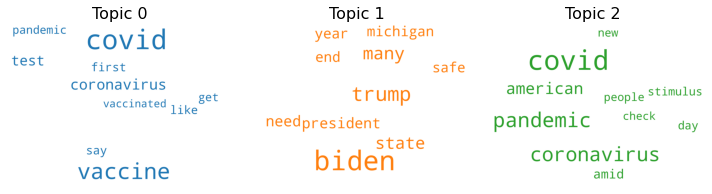

In [57]:
topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [58]:
# creating dictionary
orgPosts = allEntries[8]        #<-- posted content by Washington Post ********* 
id2word = corpora.Dictionary(orgPosts)

texts = orgPosts

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]
# creating a topic model with 3 most distinguishable topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


# printing keywords in each of the 3 topics and the weight of their contribution to that topic
lda_model.print_topics()

[(0,
  '0.021*"coronavirus" + 0.018*"pandemic" + 0.012*"analysis" + 0.010*"covid_" + 0.008*"trump" + 0.007*"vaccine" + 0.006*"death" + 0.006*"much" + 0.005*"new" + 0.005*"post"'),
 (1,
  '0.032*"coronavirus" + 0.018*"say" + 0.011*"new" + 0.010*"pandemic" + 0.010*"case" + 0.007*"state" + 0.006*"surge" + 0.006*"expert" + 0.006*"vaccine" + 0.005*"itâ"'),
 (2,
  '0.028*"coronavirus" + 0.009*"pandemic" + 0.006*"covid" + 0.005*"like" + 0.005*"more_than" + 0.004*"relief" + 0.004*"country" + 0.004*"opinion" + 0.004*"biden" + 0.004*"may"')]

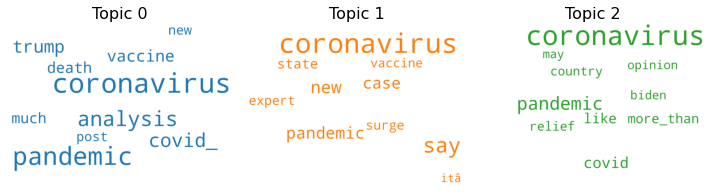

In [59]:
topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [60]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

#************************************ below is for Washington Post **************************************

vis               

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.117792  0.011515       1        1  39.634825
2      0.047897 -0.098247       2        1  30.258642
0      0.069895  0.086731       3        1  30.106533, topic_info=             Term       Freq      Total Category  logprob  loglift
160           say  32.000000  32.000000  Default  30.0000  30.0000
1176     analysis  16.000000  16.000000  Default  29.0000  29.0000
180           new  26.000000  26.000000  Default  28.0000  28.0000
811         surge  11.000000  11.000000  Default  27.0000  27.0000
488          like   7.000000   7.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
278          test   5.093620  12.959099   Topic3  -5.5865   0.2666
424      american   5.086880  12.950175   Topic3  -5.5878   0.2660
1624  perspective   4.293144   8.203615   Topic3  -5.7575   0.5529
180           new   6.175430  26.184877   Topic3  -5.3939  -0.2442
140        worker   3.843437   8.207893   Topic3  -5.8681   0.4417

[187 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
656       2  0.952236   airline
43        2  0.749150    almost
424       1  0.386095  american
424       2  0.231657  american
424       3  0.386095  american
...     ...       ...       ...
140       2  0.487336    worker
140       3  0.487336    worker
886       3  0.710425   working
269       1  0.861689      york
766       1  0.755253     young

[208 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [61]:
# creating dictionary
orgPosts = allEntries[9]           #<-- posted content by WSJ (Wall Street Journal) ********* 
id2word = corpora.Dictionary(orgPosts)

texts = orgPosts

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]

# corpus of terms in reviews frequencies
corpus = [id2word.doc2bow(text) for text in texts]
# creating a topic model with 3 most distinguishable topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


# printing keywords in each of the 3 topics and the weight of their contribution to that topic
lda_model.print_topics()

[(0,
  '0.019*"home" + 0.017*"pandemic" + 0.012*"city" + 0.008*"new_york" + 0.007*"business" + 0.007*"biden" + 0.006*"keep" + 0.006*"aid" + 0.006*"bill" + 0.006*"post"'),
 (1,
  '0.072*"covid" + 0.026*"coronavirus" + 0.012*"new" + 0.009*"opinion" + 0.009*"pandemic" + 0.008*"state" + 0.007*"vaccination" + 0.007*"case" + 0.007*"say" + 0.006*"surge"'),
 (2,
  '0.052*"vaccine" + 0.031*"covid" + 0.013*"pandemic" + 0.011*"get" + 0.010*"year" + 0.007*"first" + 0.007*"shot" + 0.006*"job" + 0.006*"company" + 0.005*"one"')]

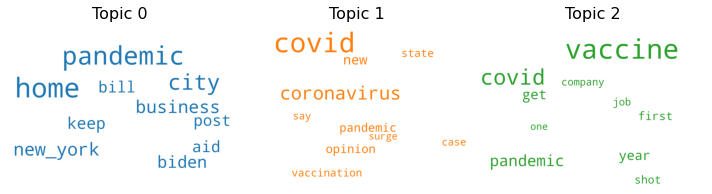

In [62]:
topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [63]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word) 

#************************************ below is for WSJ **************************************

vis    

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.196398  0.027706       1        1  50.226539
2      0.071261 -0.165354       2        1  28.996508
0      0.125137  0.137647       3        1  20.776953, topic_info=             Term         Freq        Total Category  logprob  loglift
477       vaccine   405.000000   405.000000  Default  30.0000  30.0000
119         covid  1029.000000  1029.000000  Default  29.0000  29.0000
51    coronavirus   306.000000   306.000000  Default  28.0000  28.0000
104          home    91.000000    91.000000  Default  27.0000  27.0000
59           city    57.000000    57.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
180      shortage    15.670274    17.187687   Topic3  -5.7087   1.4789
2222       street    12.133490    13.036709   Topic3  -5.9645   1.4995
1225     governor    13.830680    15.941080   Topic3  -5.8336   1.4293
14       pandemic    79.105452   271.598632   Topic3  -4.0897   0.3378
124      new_york    36.314088    81.723540   Topic3  -4.8683   0.7602

[149 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1028      3  0.966952       aid
57        1  0.972767  american
57        3  0.017371  american
289       1  0.982765      amid
930       1  0.061934      away
...     ...       ...       ...
671       1  0.980912      work
1008      3  0.939915   working
102       1  0.974711     world
2575      2  0.953627  wsj_news
25        2  0.983098      year

[164 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])